In [1]:
!ls -lah

total 624M
drwxr-xr-x  6 jovyan jovyan  192 Nov  8 11:01 .
drwxr-xr-x 37 jovyan jovyan 1.2K Nov  8 10:07 ..
drwxr-xr-x  4 jovyan jovyan  128 Nov  8 10:24 .ipynb_checkpoints
-rw-r--r--  1 jovyan jovyan 619M Nov  8 10:08 FOCI1.14-TEST.2020.04.1_1m_20110101_20111231_grid_T.nc
-rw-r--r--  1 jovyan jovyan 178K Nov  8 11:00 selection_01_no_dask.ipynb
-rw-r--r--  1 jovyan jovyan 234K Nov  8 11:01 selection_02_with_dask.ipynb


In [2]:
from dask.distributed import Client

In [3]:
client = Client(n_workers=2, threads_per_worker=2)
client

2022-11-08 11:01:27,351 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cvo578wq', purging
2022-11-08 11:01:27,353 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-nvvhvek9', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 7.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34715,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.77 GiB
Comm: tcp://127.0.0.1:44003,Total threads: 2
Dashboard: http://127.0.0.1:42959/status,Memory: 3.89 GiB
Nanny: tcp://127.0.0.1:39869,


In [4]:
import xarray as xr
import numpy as np

In [5]:
np.random.seed(123)

In [6]:
ssh = xr.open_dataset(
    "FOCI1.14-TEST.2020.04.1_1m_20110101_20111231_grid_T.nc",
    chunks={"time_counter": 1},
).sossheig
ssh = ssh.assign_coords({"x": np.arange(ssh.shape[2]), "y": np.arange(ssh.shape[1])})
ssh

<xarray.DataArray 'sossheig' (time_counter: 12, y: 511, x: 722)>
dask.array<open_dataset-fdbb8929c9ad2bfe7367e9f39547e3c4sossheig, shape=(12, 511, 722), dtype=float32, chunksize=(1, 511, 722), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 714 715 716 717 718 719 720 721
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 503 504 505 506 507 508 509 510
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  1800 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1800 s)

In [7]:
ssh.coords["nav_lon"] = ssh.coords["nav_lon"].compute()
ssh.coords["nav_lat"] = ssh.coords["nav_lat"].compute()

In [8]:
ssh

<xarray.DataArray 'sossheig' (time_counter: 12, y: 511, x: 722)>
dask.array<open_dataset-fdbb8929c9ad2bfe7367e9f39547e3c4sossheig, shape=(12, 511, 722), dtype=float32, chunksize=(1, 511, 722), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 -77.01 -77.01 -77.01 ... 50.07 50.0 50.0
    nav_lon        (y, x) float32 72.75 73.25 73.75 74.25 ... 73.01 73.0 73.0
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 714 715 716 717 718 719 720 721
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 503 504 505 506 507 508 509 510
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  1800 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1800 s)

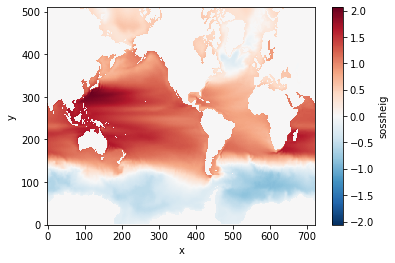

In [9]:
ssh.mean("time_counter").plot()

In [10]:
Nobs = 1_000_000

In [11]:
# %pip install xoak sklearn

In [12]:
from dask import array as darr

In [13]:
lons = xr.DataArray(
    darr.random.uniform(-180, 180, size=(Nobs, ), chunks=(Nobs // 100, )),
    dims=("obs", ),
    name="lon", 
)
lats = xr.DataArray(
    darr.random.uniform(-90, 90, size=(Nobs, ), chunks=(Nobs // 100, )),
    dims=("obs", ),
    name="lat", 
)
pos = xr.Dataset(dict(lon=lons, lat=lats))
pos

<xarray.Dataset>
Dimensions:  (obs: 1000000)
Dimensions without coordinates: obs
Data variables:
    lon      (obs) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    lat      (obs) float64 dask.array<chunksize=(10000,), meta=np.ndarray>

In [14]:
# This does not work, because `nav_lon` and `nav_lat` are 2d:
# ssh_at_pos = ssh.sel(nav_lon=pos.lon, nav_lat=pos.lat)
# ssh_at_pos

In [15]:
import xoak

In [16]:
ssh.xoak.set_index(['nav_lat', 'nav_lon'], 'sklearn_geo_balltree')

In [17]:
%%time

ssh_at_pos = ssh.xoak.sel(nav_lon=pos.lon, nav_lat=pos.lat)
ssh_at_pos

2022-11-08 11:02:08,282 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-11-08 11:02:09,072 - distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
2022-11-08 11:02:09,424 - distributed.utils_perf - WARNING - full garbage collections took 53% CPU time recently (threshold: 10%)
2022-11-08 11:02:09,794 - distributed.utils_perf - WARNING - full garbage collections took 65% CPU time recently (threshold: 10%)
2022-11-08 11:02:10,193 - distributed.utils_perf - WARNING - full garbage collections took 74% CPU time recently (threshold: 10%)
2022-11-08 11:02:10,967 - distributed.utils_perf - WARNING - full garbage collections took 71% CPU time recently (threshold: 10%)
2022-11-08 11:02:11,302 - distributed.utils_perf - WARNING - full garbage collections took 71% CPU time recently (threshold: 10%)
2022-11-08 11:02:11,659 - distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 34.7 s, sys: 2.28 s, total: 37 s
Wall time: 50.5 s


<xarray.DataArray 'sossheig' (time_counter: 12, obs: 1000000)>
dask.array<transpose, shape=(12, 1000000), dtype=float32, chunksize=(1, 1000000), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (obs) float32 -14.35 55.48 29.52 38.78 ... 68.1 -43.93 -77.01
    nav_lon        (obs) float32 -103.2 -178.6 136.2 ... 57.97 -76.25 -104.8
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
    x              (obs) int64 368 216 127 520 425 402 ... 252 576 624 422 365
    y              (obs) int64 220 380 311 333 0 351 216 ... 113 164 0 482 151 0
Dimensions without coordinates: obs
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  1800 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1800 s)

In [18]:
ssh_at_pos.std("obs").compute()

<xarray.DataArray 'sossheig' (time_counter: 12)>
array([0.63032466, 0.6285923 , 0.6284936 , 0.6351791 , 0.63647646,
       0.63955736, 0.63657767, 0.6421162 , 0.6432517 , 0.6425179 ,
       0.6384001 , 0.63302207], dtype=float32)
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
  * time_counter   (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...